# ATC40 - Capacity Spectrum Method (Proc. B)

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from streng.tools.bilin import Bilin
import streng.codes.eurocodes.ec8.cls.seismic_action.spectra as spec_ec8
from streng.codes.eurocodes.ec8.raw.ch3.seismic_action.spectra import η
from streng.codes.usa.atc40.cls.nl_static_analysis.csm import CapacitySpectrumMethodProcedureB as csm_procB
from streng.codes.usa.atc40.cls.nl_static_analysis.csm import StructureProperties, Demand
from streng.common.math.numerical import intersection

In [2]:
bl = Bilin()
# bl.load_space_delimited(r'D:/MyBooks/TEI/RepairsExample/sapfiles/fema/PushoverCurve_modal.pushcurve', ' ')
bl.curve_ini.load_delimited(r'http://seivas.net/mkd/PushoverCurve_modal.pushcurve', ' ')

mystructure = StructureProperties(m = np.array([39.08, 39.08, 39.08]),
                                  φ = np.array([0.0483, 0.0920, 0.1217]),
                                  T0 = 0.753,
                                  pushover_curve_F = bl.curve_ini.y,
                                  pushover_curve_δ = bl.curve_ini.x,
                                  behavior ='A')

## Βήματα 1 και 2

In [3]:
damps = list(range(5, 41, 5))
T_range = np.linspace(1e-10, 4, 401)

mydemands = []
for d in damps:
    dem = Demand(T_range=T_range,
                  Sa=None,
                  Sd=None,
                  TC=None)
    dem.ec8_elastic(αgR=0.24*9.81,
                          γI=1.0,
                          ground_type = 'C',
                          spectrum_type = 1,
                          η = η(d),
                          q=1.0,
                          β=0.2)
    mydemands.append({'damping': d, 'demand': dem})

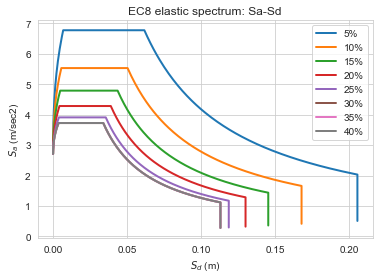

In [4]:
for dem in mydemands:
    plt.plot(dem['demand'].Sd, dem['demand'].Sa, lw=2, label=f'{dem["damping"]}%')
plt.ylabel('$S_{a}$ (m/sec2)') 
plt.xlabel('$S_{d}$ (m)') 
plt.title('EC8 elastic spectrum: Sa-Sd')
plt.legend()
plt.show()

## Βήμα 3

In [5]:
mycsm = csm_procB(structure = mystructure,
                  demands = mydemands)

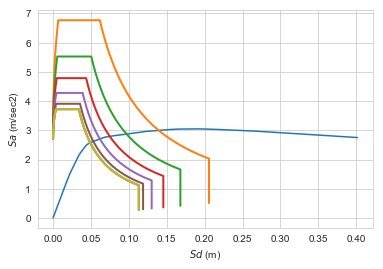

In [6]:
plt.plot(mycsm.structure.Sd, mycsm.structure.Sa)
for dem in mycsm.demands:
    plt.plot(dem['demand'].Sd, dem['demand'].Sa, lw=2, label=f'{dem["damping"]}%')
plt.ylabel('$Sa$ (m/sec2)') 
plt.xlabel('$Sd$ (m)')
plt.show()

## Βήμα 4

In [7]:
mycsm.calc_performance_point()
print(f'd*={mycsm.dstar_intersection[0]:.3f}')
print(f'a(d*)={mycsm.dstar_intersection[1]:.3f}m/sec2. Προσοχή, είναι το σημείο τομής, όχι το a*')

d*=0.079
a(d*)=5.257m/sec2. Προσοχή, είναι το σημείο τομής, όχι το a*


### Διγραμμική καμπύλη μέχρι το d*

In [8]:
print(mycsm.bilinear_curve.all_quantities)

| quantity   |     value |
|:-----------|----------:|
| x_0        | 0.000E+00 |
| x_y        | 3.484E-02 |
| x_u        | 7.948E-02 |
| y_0        | 0.000E+00 |
| y_y        | 2.381E+00 |
| y_u        | 2.811E+00 |
| kel        | 6.835E+01 |
| kinel      | 9.618E+00 |
| μ          | 2.281E+00 |
| α          | 1.407E-01 |


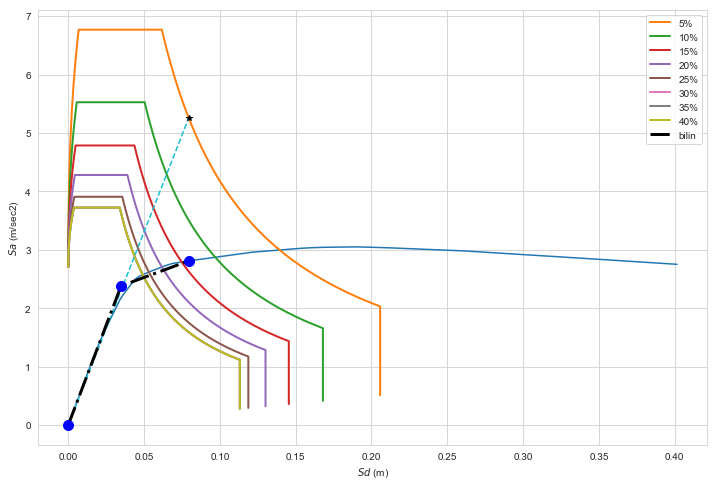

In [9]:
plt.figure(figsize=(12,8))
plt.plot(mycsm.structure.Sd, mycsm.structure.Sa)
for dem in mycsm.demands:
    plt.plot(dem['demand'].Sd, dem['demand'].Sa, lw=2, label=f'{dem["damping"]}%')
plt.plot([0, mycsm.dstar_intersection[0]], [0, mycsm.dstar_intersection[1]],'--')  
plt.plot(mycsm.dstar_intersection[0], mycsm.dstar_intersection[1],'*k')
plt.plot(mycsm.bilinear_curve.d_array, mycsm.bilinear_curve.a_array, '-.', lw=3, color='black', label='bilin')
plt.plot(mycsm.bilinear_curve.d_array, mycsm.bilinear_curve.a_array, 'bo', markersize=10)
plt.ylabel('$Sa$ (m/sec2)') 
plt.xlabel('$Sd$ (m)')
plt.legend()             
plt.show()

In [10]:
print(f'a*={mycsm.astar:.2f}m/sec2')

a*=2.81m/sec2


## Βήμα 5

Παίρνω μερικές τιμές της dpi λίγο πριν και λίγο μετά την d\*. Εδώ χρησιμοποιώ 11 τιμές, από 0.5d\* έως 1.5d\*.
Στη συνέχεις υπολογίζω τα αντίστοιχα api, β0, βeff για κάθε dpi

In [11]:
print(f'dpi_rng = {mycsm.dpi_rng}')
print(f'api_rng = {mycsm.api_rng}')
print(f'β0_rng = {mycsm.β0_rng}')
print(f'βeff_rng = {mycsm.βeff_rng}')

dpi_rng = [0.03973914 0.04768696 0.05563479 0.06358262 0.07153044 0.07947827
 0.0874261  0.09537392 0.10332175 0.11126958 0.11921741]
api_rng = [2.42829909 2.50474221 2.58118532 2.65762843 2.73407154 2.81051465
 2.88695776 2.96340087 3.03984398 3.11628709 3.1927302 ]
β0_rng = [0.06615026 0.1401169  0.18863524 0.22157418 0.24438408 0.26030995
 0.27139694 0.27899262 0.28401713 0.28711728 0.28875883]
βeff_rng = [0.11615026 0.1901169  0.23465186 0.26104843 0.27830909 0.28986627
 0.29767203 0.30290606 0.30631755 0.30840228 0.30949992]


## Βήμα 6

### Υπολογίζω τα καινούρια φάσματα Sa-Sd για κάθε τιμή της βeff

Εδώ το ATC40 το κάνει γραφικά, γι'αυτό και χρησιμοποιεί τα πολλά σχεδιασμένα φάσματα. Τελικά τα πολλά για αποσβέσεις που διαφέρουν 5% δεν τα χρησιμοποιώ καθόλου στον υπολογισμό.

In [12]:
new_demands = []
for d in mycsm.βeff_rng :
    dem = Demand(T_range=T_range,
                  Sa=None,
                  Sd=None,
                  TC=None)
    dem.ec8_elastic(αgR=0.24*9.81,
                          γI=1.0,
                          ground_type = 'C',
                          spectrum_type = 1,
                          η = η(100*d),
                          q=1.0,
                          β=0.2)
    new_demands.append({'damping': d, 'demand': dem})

In [13]:
api_rng = []
for i, dem in enumerate(new_demands):
    _Sa = dem['demand'].Sa
    _Sd = dem['demand'].Sd
    
    _api = np.interp(mycsm.dpi_rng[i], _Sd, _Sa)
    api_rng.append(_api)

## Βήμα 7

Για κάθε νέο φάσμα βρίσκω την Sa που αντιστοιχεί σε κάθε dpi. Στη συνέχεια ενώνω με μια γραμμή τα σημεία αυτά και από την τομή με την καμπύλη αντίστασης έχω τη λύση για την Sd

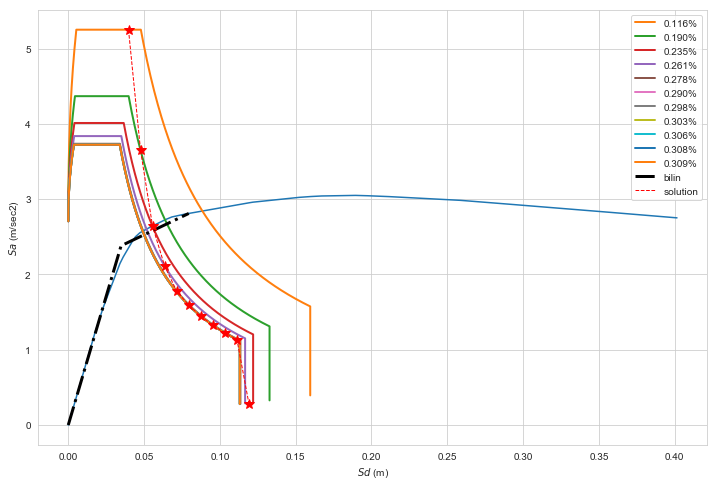

In [14]:
plt.figure(figsize=(12,8))
plt.plot(mycsm.structure.Sd, mycsm.structure.Sa)
for dem in new_demands:
    plt.plot(dem['demand'].Sd, dem['demand'].Sa, lw=2, label=f'{dem["damping"]:.3f}%')
plt.plot(mycsm.bilinear_curve.d_array, mycsm.bilinear_curve.a_array, '-.', lw=3, color='black', label='bilin')
             
plt.plot(mycsm.dpi_rng, api_rng,'*k', color='red', markersize=10)
plt.plot(mycsm.dpi_rng, api_rng,'--', lw=1, color='red', label='solution')
             
plt.ylabel('$Sa$ (m/sec2)') 
plt.xlabel('$Sd$ (m)')
plt.legend()             
plt.show()

In [15]:
solution_sd, solution_sa = intersection(mycsm.dpi_rng, np.array(api_rng), mycsm.structure.Sd, mycsm.structure.Sa)

In [16]:
print(f'Λύση: Sd={solution_sd[0]:.3f}m - Sa={solution_sa[0]:.2f}m/sec2')

Λύση: Sd=0.056m - Sa=2.64m/sec2
